# Import Packages

In [127]:
# Import packages
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy.stats import beta

# Algorithms 
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [128]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [129]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)
    print(len(history["mean"]))
    count = 0
    for v in history["mean"]:
        print(v/temp)
        print(count)
        count += 1
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1

In [130]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values))
    
    return chosen_arm

### Bayesian UCB

In [131]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3)
    
    return chosen_arm

### Thompson Sampling

In [132]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x])
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy

In [133]:
def epsilon_greedy_policy(history, arms, epsilon=0.1):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return rec

### Softmax

In [134]:
def softmax(history, arms, temp = 1):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [135]:
logs_df = pd.read_csv("cleaned_dataset.csv")
logs_df

,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD
0,Y,N,N,Y,N,N,2,Alive and still dependent
1,Y,Y,Y,Y,Y,Y,4,Dead while dependent
2,Y,N,N,Y,N,N,2,Alive and still dependent
3,Y,Y,Y,Y,Y,Y,4,Dead while dependent
4,Y,Y,Y,Y,Y,Y,4,Dead while dependent
...,...,...,...,...,...,...,...,...
17141,Y,Y,Y,Y,Y,Y,4,Dead while dependent
17142,Y,Y,Y,Y,Y,Y,4,Dead while dependent
17143,Y,Y,Y,Y,Y,Y,4,Dead while dependent
17144,N,N,N,Y,N,N,1,Alive and still dependent


In [136]:
def reward_value(reward):
    dead_dep = logs_df["REWARD"].value_counts()[0]
    alive_dep = logs_df["REWARD"].value_counts()[1]
    alive_rec = logs_df["REWARD"].value_counts()[2]
    total_count = sum(logs_df["REWARD"].value_counts())
    
    if reward == 'Alive and still dependent':
        return alive_dep / total_count 
    elif reward == 'Dead while dependent':
        return dead_dep / total_count
    else:
        return alive_rec / total_count

logs_df["REWARD_VALUE"] = logs_df["REWARD"].apply(reward_value)

In [137]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(3):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [138]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)

In [139]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [annealing_softmax, ucb1, bayesian_ucb, thompson_sampling]

# Define a dataframe for evaluation results
evaluation = []

# Define a list to save all arm-play statistics
play_stats = []

# Running bootstrap replay
for f in algos:

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 'alpha': 'int32', 'beta': 'int32'})

        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1]
        
        step = 0

        # Go through every entry of the dataframe
        for i in range(1, log_length * len(arms) + 1):
            # Get recommendation from the algorithm
            rec_a = f(container, arms)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE'] # get the reward value
                regret = 1 - reward

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'reward':reward, 'regret':regret}
                evaluation.append(eva_rec)

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

3
0.0
0
0.0
1
0.0
2
3
0.0
0
0.0
1
0.0
2
3
0.0
0
0.7556281348419457
1
0.0
2
3
0.0
0
0.7556281348419457
1
0.0
2
3
0.0
0
0.9445351685524319
1
0.0
2
3
0.0
0
1.1334422022629185
1
0.0
2
3
0.0
0
1.3223492359734048
1
0.0
2
3
0.0
0
1.3223492359734048
1
0.0
2
3
0.0
0
1.5112562696838916
1
0.0
2
3
0.0
0
1.5112562696838916
1
0.0
2
3
0.0
0
1.5112562696838916
1
0.0
2
3
0.0
0
1.7001633033943775
1
0.0
2
3
0.0
0
1.8890703371048638
1
0.0
2
3
0.0
0
1.8890703371048638
1
0.0
2
3
0.0
0
1.8890703371048638
1
0.0
2
3
0.0
0
1.8890703371048638
1
0.0
2
3
0.0
0
1.8890703371048638
1
0.0
2
3
0.0
0
2.0779773708153497
1
0.0
2
3
0.0
0
2.0779773708153497
1
0.0
2
3
0.0
0
2.2668844045258365
1
0.0
2
3
0.0
0
2.2668844045258365
1
0.0
2
3
0.0
0
2.2668844045258365
1
0.0
2
3
0.0
0
2.4557914382363233
1
0.0
2
3
0.0
0
2.4557914382363233
1
0.0
2
3
0.0
0
2.4557914382363233
1
0.0
2
3
0.0
0
2.644698471946809
1
0.0
2
3
0.0
0
2.644698471946809
1
0.0
2
3
0.0
0
2.644698471946809
1
0.0
2
3
0.0
0
2.644698471946809
1
0.0
2
3
0.0
0
2.644698471

3
0.0
0
32.30310276449321
1
0.0
2
3
0.0
0
32.492009798203696
1
0.0
2
3
0.0
0
32.492009798203696
1
0.0
2
3
0.0
0
32.492009798203696
1
0.0
2
3
0.0
0
32.68091683191418
1
0.0
2
3
0.0
0
32.869823865624674
1
0.0
2
3
0.0
0
32.869823865624674
1
0.0
2
3
0.0
0
32.869823865624674
1
0.0
2
3
0.0
0
32.869823865624674
1
0.0
2
3
0.0
0
32.869823865624674
1
0.0
2
3
0.0
0
33.05873089933516
1
0.0
2
3
0.0
0
33.247637933045645
1
0.0
2
3
0.0
0
33.43654496675614
1
0.0
2
3
0.0
0
33.43654496675614
1
0.0
2
3
0.0
0
33.43654496675614
1
0.0
2
3
0.0
0
33.62545200046663
1
0.0
2
3
0.0
0
33.814359034177116
1
0.0
2
3
0.0
0
33.814359034177116
1
0.0
2
3
0.0
0
33.814359034177116
1
0.0
2
3
0.0
0
33.814359034177116
1
0.0
2
3
0.0
0
34.0032660678876
1
0.0
2
3
0.0
0
34.19217310159809
1
0.0
2
3
0.0
0
34.38108013530857
1
0.0
2
3
0.0
0
34.38108013530857
1
0.0
2
3
0.0
0
34.56998716901906
1
0.0
2
3
0.0
0
34.75889420272956
1
0.0
2
3
0.0
0
34.947801236440036
1
0.0
2
3
0.0
0
35.13670827015053
1
0.0
2
3
0.0
0
35.32561530386102
1
0.0
2
3

3
0.0
0
62.339321124460774
1
0.0
2
3
0.0
0
62.52822815817125
1
0.0
2
3
0.0
0
62.52822815817125
1
0.0
2
3
0.0
0
62.71713519188175
1
0.0
2
3
0.0
0
62.71713519188175
1
0.0
2
3
0.0
0
62.90604222559224
1
0.0
2
3
0.0
0
63.09494925930272
1
0.0
2
3
0.0
0
63.283856293013216
1
0.0
2
3
0.0
0
63.4727633267237
1
0.0
2
3
0.0
0
63.4727633267237
1
0.0
2
3
0.0
0
63.4727633267237
1
0.0
2
3
0.0
0
63.66167036043418
1
0.0
2
3
0.0
0
63.85057739414467
1
0.0
2
3
0.0
0
64.03948442785516
1
0.0
2
3
0.0
0
64.22839146156565
1
0.0
2
3
0.0
0
64.41729849527614
1
0.0
2
3
0.0
0
64.41729849527614
1
0.0
2
3
0.0
0
64.60620552898662
1
0.0
2
3
0.0
0
64.60620552898662
1
0.0
2
3
0.0
0
64.7951125626971
1
0.0
2
3
0.0
0
64.98401959640759
1
0.0
2
3
0.0
0
65.1729266301181
1
0.0
2
3
0.0
0
65.36183366382858
1
0.0
2
3
0.0
0
65.36183366382858
1
0.0
2
3
0.0
0
65.36183366382858
1
0.0
2
3
0.0
0
65.36183366382858
1
0.0
2
3
0.0
0
65.55074069753907
1
0.0
2
3
0.0
0
65.73964773124956
1
0.0
2
3
0.0
0
65.92855476496004
1
0.0
2
3
0.0
0
66.117461

3
0.0
0
94.4535168552437
1
0.0
2
3
0.0
0
94.64242388895418
1
0.0
2
3
0.0
0
94.64242388895418
1
0.0
2
3
0.0
0
94.64242388895418
1
0.0
2
3
0.0
0
94.83133092266468
1
0.0
2
3
0.0
0
94.83133092266468
1
0.0
2
3
0.0
0
95.02023795637515
1
0.0
2
3
0.0
0
95.20914499008566
1
0.0
2
3
0.0
0
95.39805202379614
1
0.0
2
3
0.0
0
95.39805202379614
1
0.0
2
3
0.0
0
95.58695905750662
1
0.0
2
3
0.0
0
95.77586609121713
1
0.0
2
3
0.0
0
95.77586609121713
1
0.0
2
3
0.0
0
95.9647731249276
1
0.0
2
3
0.0
0
95.9647731249276
1
0.0
2
3
0.0
0
96.1536801586381
1
0.0
2
3
0.0
0
96.1536801586381
1
0.0
2
3
0.0
0
96.1536801586381
1
0.0
2
3
0.0
0
96.1536801586381
1
0.0
2
3
0.0
0
96.1536801586381
1
0.0
2
3
0.0
0
96.34258719234857
1
0.0
2
3
0.0
0
96.53149422605907
1
0.0
2
3
0.0
0
96.53149422605907
1
0.0
2
3
0.0
0
96.53149422605907
1
0.0
2
3
0.0
0
96.72040125976956
1
0.0
2
3
0.0
0
96.72040125976956
1
0.0
2
3
0.0
0
96.90930829348005
1
0.0
2
3
0.0
0
97.09821532719053
1
0.0
2
3
0.0
0
97.28712236090101
1
0.0
2
3
0.0
0
97.47602939461

3
0.0
0
122.78957191181685
1
0.0
2
3
0.0
0
122.78957191181685
1
0.0
2
3
0.0
0
122.78957191181685
1
0.0
2
3
0.0
0
122.78957191181685
1
0.0
2
3
0.0
0
122.97847894552736
1
0.0
2
3
0.0
0
123.16738597923785
1
0.0
2
3
0.0
0
123.35629301294831
1
0.0
2
3
0.0
0
123.5452000466588
1
0.0
2
3
0.0
0
123.7341070803693
1
0.0
2
3
0.0
0
123.92301411407978
1
0.0
2
3
0.0
0
123.92301411407978
1
0.0
2
3
0.0
0
124.11192114779028
1
0.0
2
3
0.0
0
124.11192114779028
1
0.0
2
3
0.0
0
124.11192114779028
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.30082818150078
1
0.0
2
3
0.0
0
124.48973521521125
1
0.0
2
3
0.0
0
124.67864224892175
1
0.0
2
3
0.0
0
124.86754928263223
1
0.0
2
3
0.0
0
124.86754928263223
1
0.0
2
3
0.0
0
124.86754928263223
1
0.0
2
3
0.0
0
124.86754928263223
1
0.0
2
3
0.0
0
125.0564563163427
1
0.0
2
3
0.0
0
125.05645631634

3
0.0
0
150.3699988335481
1
0.0
2
3
0.0
0
150.3699988335481
1
0.0
2
3
0.0
0
150.55890586725857
1
0.0
2
3
0.0
0
150.74781290096908
1
0.0
2
3
0.0
0
150.93671993467956
1
0.0
2
3
0.0
0
150.93671993467956
1
0.0
2
3
0.0
0
150.93671993467956
1
0.0
2
3
0.0
0
151.12562696839007
1
0.0
2
3
0.0
0
151.31453400210054
1
0.0
2
3
0.0
0
151.31453400210054
1
0.0
2
3
0.0
0
151.31453400210054
1
0.0
2
3
0.0
0
151.50344103581102
1
0.0
2
3
0.0
0
151.69234806952153
1
0.0
2
3
0.0
0
151.881255103232
1
0.0
2
3
0.0
0
151.881255103232
1
0.0
2
3
0.0
0
152.07016213694246
1
0.0
2
3
0.0
0
152.07016213694246
1
0.0
2
3
0.0
0
152.259069170653
1
0.0
2
3
0.0
0
152.259069170653
1
0.0
2
3
0.0
0
152.44797620436347
1
0.0
2
3
0.0
0
152.44797620436347
1
0.0
2
3
0.0
0
152.44797620436347
1
0.0
2
3
0.0
0
152.44797620436347
1
0.0
2
3
0.0
0
152.63688323807395
1
0.0
2
3
0.0
0
152.63688323807395
1
0.0
2
3
0.0
0
152.82579027178446
1
0.0
2
3
0.0
0
152.82579027178446
1
0.0
2
3
0.0
0
153.0146973054949
1
0.0
2
3
0.0
0
153.2036043392054
1
0.0

3
0.0
0
173.98337804735877
1
0.0
2
3
0.0
0
174.17228508106925
1
0.0
2
3
0.0
0
174.17228508106925
1
0.0
2
3
0.0
0
174.17228508106925
1
0.0
2
3
0.0
0
174.36119211477973
1
0.0
2
3
0.0
0
174.36119211477973
1
0.0
2
3
0.0
0
174.55009914849018
1
0.0
2
3
0.0
0
174.73900618220063
1
0.0
2
3
0.0
0
174.73900618220063
1
0.0
2
3
0.0
0
174.92791321591113
1
0.0
2
3
0.0
0
175.11682024962158
1
0.0
2
3
0.0
0
175.30572728333206
1
0.0
2
3
0.0
0
175.30572728333206
1
0.0
2
3
0.0
0
175.49463431704254
1
0.0
2
3
0.0
0
175.49463431704254
1
0.0
2
3
0.0
0
175.68354135075302
1
0.0
2
3
0.0
0
175.68354135075302
1
0.0
2
3
0.0
0
175.87244838446347
1
0.0
2
3
0.0
0
176.06135541817395
1
0.0
2
3
0.0
0
176.25026245188442
1
0.0
2
3
0.0
0
176.25026245188442
1
0.0
2
3
0.0
0
176.25026245188442
1
0.0
2
3
0.0
0
176.43916948559487
1
0.0
2
3
0.0
0
176.62807651930538
1
0.0
2
3
0.0
0
176.81698355301583
1
0.0
2
3
0.0
0
177.00589058672628
1
0.0
2
3
0.0
0
177.19479762043673
1
0.0
2
3
0.0
0
177.19479762043673
1
0.0
2
3
0.0
0
177.19479762

3
0.0
0
203.4528753061919
1
0.0
2
3
0.0
0
203.6417823399024
1
0.0
2
3
0.0
0
203.83068937361284
1
0.0
2
3
0.0
0
203.83068937361284
1
0.0
2
3
0.0
0
204.01959640732332
1
0.0
2
3
0.0
0
204.2085034410338
1
0.0
2
3
0.0
0
204.39741047474425
1
0.0
2
3
0.0
0
204.58631750845473
1
0.0
2
3
0.0
0
204.77522454216518
1
0.0
2
3
0.0
0
204.96413157587568
1
0.0
2
3
0.0
0
205.15303860958616
1
0.0
2
3
0.0
0
205.34194564329658
1
0.0
2
3
0.0
0
205.34194564329658
1
0.0
2
3
0.0
0
205.34194564329658
1
0.0
2
3
0.0
0
205.5308526770071
1
0.0
2
3
0.0
0
205.71975971071757
1
0.0
2
3
0.0
0
205.71975971071757
1
0.0
2
3
0.0
0
205.908666744428
1
0.0
2
3
0.0
0
205.908666744428
1
0.0
2
3
0.0
0
206.0975737781385
1
0.0
2
3
0.0
0
206.0975737781385
1
0.0
2
3
0.0
0
206.28648081184892
1
0.0
2
3
0.0
0
206.47538784555942
1
0.0
2
3
0.0
0
206.66429487926993
1
0.0
2
3
0.0
0
206.85320191298035
1
0.0
2
3
0.0
0
206.85320191298035
1
0.0
2
3
0.0
0
207.04210894669083
1
0.0
2
3
0.0
0
207.2310159804013
1
0.0
2
3
0.0
0
207.41992301411176
1
0.

3
0.0
0
237.26723434036583
1
0.0
2
3
0.0
0
237.26723434036583
1
0.0
2
3
0.0
0
237.45614137407628
1
0.0
2
3
0.0
0
237.45614137407628
1
0.0
2
3
0.0
0
237.45614137407628
1
0.0
2
3
0.0
0
237.64504840778676
1
0.0
2
3
0.0
0
237.8339554414973
1
0.0
2
3
0.0
0
238.0228624752077
1
0.0
2
3
0.0
0
238.21176950891817
1
0.0
2
3
0.0
0
238.40067654262867
1
0.0
2
3
0.0
0
238.5895835763391
1
0.0
2
3
0.0
0
238.77849061004957
1
0.0
2
3
0.0
0
238.77849061004957
1
0.0
2
3
0.0
0
238.77849061004957
1
0.0
2
3
0.0
0
238.96739764376008
1
0.0
2
3
0.0
0
239.15630467747053
1
0.0
2
3
0.0
0
239.15630467747053
1
0.0
2
3
0.0
0
239.15630467747053
1
0.0
2
3
0.0
0
239.15630467747053
1
0.0
2
3
0.0
0
239.34521171118095
1
0.0
2
3
0.0
0
239.34521171118095
1
0.0
2
3
0.0
0
239.34521171118095
1
0.0
2
3
0.0
0
239.53411874489146
1
0.0
2
3
0.0
0
239.72302577860196
1
0.0
2
3
0.0
0
239.9119328123124
1
0.0
2
3
0.0
0
240.10083984602286
1
0.0
2
3
0.0
0
240.28974687973337
1
0.0
2
3
0.0
0
240.28974687973337
1
0.0
2
3
0.0
0
240.289746879733

3
0.0
0
272.0261285430921
1
0.0
2
3
0.0
0
272.2150355768026
1
0.0
2
3
0.0
0
272.403942610513
1
0.0
2
3
0.0
0
272.5928496442235
1
0.0
2
3
0.0
0
272.5928496442235
1
0.0
2
3
0.0
0
272.78175667793397
1
0.0
2
3
0.0
0
272.78175667793397
1
0.0
2
3
0.0
0
272.97066371164453
1
0.0
2
3
0.0
0
273.15957074535487
1
0.0
2
3
0.0
0
273.3484777790654
1
0.0
2
3
0.0
0
273.3484777790654
1
0.0
2
3
0.0
0
273.5373848127759
1
0.0
2
3
0.0
0
273.5373848127759
1
0.0
2
3
0.0
0
273.72629184648633
1
0.0
2
3
0.0
0
273.91519888019684
1
0.0
2
3
0.0
0
274.1041059139073
1
0.0
2
3
0.0
0
274.29301294761774
1
0.0
2
3
0.0
0
274.29301294761774
1
0.0
2
3
0.0
0
274.4819199813282
1
0.0
2
3
0.0
0
274.6708270150387
1
0.0
2
3
0.0
0
274.6708270150387
1
0.0
2
3
0.0
0
274.6708270150387
1
0.0
2
3
0.0
0
274.6708270150387
1
0.0
2
3
0.0
0
274.85973404874915
1
0.0
2
3
0.0
0
274.85973404874915
1
0.0
2
3
0.0
0
275.0486410824596
1
0.0
2
3
0.0
0
275.2375481161701
1
0.0
2
3
0.0
0
275.42645514988055
1
0.0
2
3
0.0
0
275.42645514988055
1
0.0
2
3
0

3
0.0
0
303.5736031727404
1
0.0
2
3
0.0
0
303.5736031727404
1
0.0
2
3
0.0
0
303.7625102064509
1
0.0
2
3
0.0
0
303.9514172401614
1
0.0
2
3
0.0
0
304.1403242738718
1
0.0
2
3
0.0
0
304.3292313075823
1
0.0
2
3
0.0
0
304.5181383412928
1
0.0
2
3
0.0
0
304.7070453750032
1
0.0
2
3
0.0
0
304.8959524087137
1
0.0
2
3
0.0
0
305.08485944242415
1
0.0
2
3
0.0
0
305.2737664761346
1
0.0
2
3
0.0
0
305.2737664761346
1
0.0
2
3
0.0
0
305.4626735098451
1
0.0
2
3
0.0
0
305.4626735098451
1
0.0
2
3
0.0
0
305.4626735098451
1
0.0
2
3
0.0
0
305.6515805435556
1
0.0
2
3
0.0
0
305.840487577266
1
0.0
2
3
0.0
0
305.840487577266
1
0.0
2
3
0.0
0
305.840487577266
1
0.0
2
3
0.0
0
306.02939461097645
1
0.0
2
3
0.0
0
306.02939461097645
1
0.0
2
3
0.0
0
306.21830164468696
1
0.0
2
3
0.0
0
306.21830164468696
1
0.0
2
3
0.0
0
306.4072086783974
1
0.0
2
3
0.0
0
306.4072086783974
1
0.0
2
3
0.0
0
306.5961157121079
1
0.0
2
3
0.0
0
306.7850227458184
1
0.0
2
3
0.0
0
306.9739297795289
1
0.0
2
3
0.0
0
307.1628368132393
1
0.0
2
3
0.0
0
307.

3
0.0
0
336.63233407207247
1
0.0
2
3
0.0
0
336.821241105783
1
0.0
2
3
0.0
0
336.821241105783
1
0.0
2
3
0.0
0
336.821241105783
1
0.0
2
3
0.0
0
337.01014813949337
1
0.0
2
3
0.0
0
337.1990551732038
1
0.0
2
3
0.0
0
337.1990551732038
1
0.0
2
3
0.0
0
337.3879622069143
1
0.0
2
3
0.0
0
337.3879622069143
1
0.0
2
3
0.0
0
337.5768692406248
1
0.0
2
3
0.0
0
337.5768692406248
1
0.0
2
3
0.0
0
337.5768692406248
1
0.0
2
3
0.0
0
337.5768692406248
1
0.0
2
3
0.0
0
337.5768692406248
1
0.0
2
3
0.0
0
337.7657762743353
1
0.0
2
3
0.0
0
337.7657762743353
1
0.0
2
3
0.0
0
337.9546833080458
1
0.0
2
3
0.0
0
338.1435903417562
1
0.0
2
3
0.0
0
338.1435903417562
1
0.0
2
3
0.0
0
338.33249737546663
1
0.0
2
3
0.0
0
338.52140440917714
1
0.0
2
3
0.0
0
338.7103114428876
1
0.0
2
3
0.0
0
338.7103114428876
1
0.0
2
3
0.0
0
338.8992184765981
1
0.0
2
3
0.0
0
339.08812551030854
1
0.0
2
3
0.0
0
339.27703254401905
1
0.0
2
3
0.0
0
339.4659395777295
1
0.0
2
3
0.0
0
339.4659395777295
1
0.0
2
3
0.0
0
339.65484661143995
1
0.0
2
3
0.0
0
33

3
0.0
0
370.2577860725359
1
0.0
2
3
0.0
0
370.44669310624636
1
0.0
2
3
0.0
0
370.44669310624636
1
0.0
2
3
0.0
0
370.63560013995686
1
0.0
2
3
0.0
0
370.63560013995686
1
0.0
2
3
0.0
0
370.63560013995686
1
0.0
2
3
0.0
0
370.63560013995686
1
0.0
2
3
0.0
0
370.63560013995686
1
0.0
2
3
0.0
0
370.8245071736673
1
0.0
2
3
0.0
0
371.01341420737776
1
0.0
2
3
0.0
0
371.20232124108827
1
0.0
2
3
0.0
0
371.3912282747988
1
0.0
2
3
0.0
0
371.5801353085092
1
0.0
2
3
0.0
0
371.5801353085092
1
0.0
2
3
0.0
0
371.7690423422196
1
0.0
2
3
0.0
0
371.7690423422196
1
0.0
2
3
0.0
0
371.7690423422196
1
0.0
2
3
0.0
0
371.7690423422196
1
0.0
2
3
0.0
0
371.7690423422196
1
0.0
2
3
0.0
0
371.9579493759301
1
0.0
2
3
0.0
0
372.1468564096405
1
0.0
2
3
0.0
0
372.1468564096405
1
0.0
2
3
0.0
0
372.1468564096405
1
0.0
2
3
0.0
0
372.3357634433511
1
0.0
2
3
0.0
0
372.52467047706153
1
0.0
2
3
0.0
0
372.52467047706153
1
0.0
2
3
0.0
0
372.713577510772
1
0.0
2
3
0.0
0
372.713577510772
1
0.0
2
3
0.0
0
372.9024845444825
1
0.0
2
3
0.0

3
0.0
0
403.12760993815743
1
0.0
2
3
0.0
0
403.12760993815743
1
0.0
2
3
0.0
0
403.31651697186794
1
0.0
2
3
0.0
0
403.50542400557845
1
0.0
2
3
0.0
0
403.50542400557845
1
0.0
2
3
0.0
0
403.69433103928895
1
0.0
2
3
0.0
0
403.88323807299935
1
0.0
2
3
0.0
0
403.88323807299935
1
0.0
2
3
0.0
0
404.07214510670985
1
0.0
2
3
0.0
0
404.07214510670985
1
0.0
2
3
0.0
0
404.26105214042036
1
0.0
2
3
0.0
0
404.4499591741308
1
0.0
2
3
0.0
0
404.63886620784126
1
0.0
2
3
0.0
0
404.63886620784126
1
0.0
2
3
0.0
0
404.63886620784126
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
404.82777324155165
1
0.0
2
3
0.0
0
405.0166802752621
1
0.0
2
3
0.0
0
405.0166802752621
1
0.0
2
3
0.0
0
405.2055873089726
1
0.0
2
3
0.0
0
405.2055873089726
1
0.0
2
3
0.0
0
405.3944943426832
1
0.0
2
3
0.0
0
405.3944943426832
1
0.0
2
3
0.0
0
405.58340137639357
1
0.0
2
3
0.0
0
405.58340137639357


3
0.0
0
429.7635016913336
1
0.0
2
3
0.0
0
429.95240872504405
1
0.0
2
3
0.0
0
430.14131575875456
1
0.0
2
3
0.0
0
430.33022279246507
1
0.0
2
3
0.0
0
430.51912982617546
1
0.0
2
3
0.0
0
430.51912982617546
1
0.0
2
3
0.0
0
430.51912982617546
1
0.0
2
3
0.0
0
430.708036859886
1
0.0
2
3
0.0
0
430.708036859886
1
0.0
2
3
0.0
0
430.8969438935964
1
0.0
2
3
0.0
0
431.08585092730686
1
0.0
2
3
0.0
0
431.2747579610173
1
0.0
2
3
0.0
0
431.2747579610173
1
0.0
2
3
0.0
0
431.4636649947278
1
0.0
2
3
0.0
0
431.65257202843827
1
0.0
2
3
0.0
0
431.8414790621488
1
0.0
2
3
0.0
0
432.0303860958593
1
0.0
2
3
0.0
0
432.2192931295697
1
0.0
2
3
0.0
0
432.2192931295697
1
0.0
2
3
0.0
0
432.4082001632802
1
0.0
2
3
0.0
0
432.5971071969907
1
0.0
2
3
0.0
0
432.5971071969907
1
0.0
2
3
0.0
0
432.78601423070114
1
0.0
2
3
0.0
0
432.78601423070114
1
0.0
2
3
0.0
0
432.78601423070114
1
0.0
2
3
0.0
0
432.78601423070114
1
0.0
2
3
0.0
0
432.78601423070114
1
0.0
2
3
0.0
0
432.9749212644116
1
0.0
2
3
0.0
0
433.163828298122
1
0.0
2
3
0.

3
0.0
0
462.63332555695524
1
0.0
2
3
0.0
0
462.82223259066564
1
0.0
2
3
0.0
0
462.82223259066564
1
0.0
2
3
0.0
0
462.82223259066564
1
0.0
2
3
0.0
0
463.0111396243762
1
0.0
2
3
0.0
0
463.0111396243762
1
0.0
2
3
0.0
0
463.2000466580866
1
0.0
2
3
0.0
0
463.388953691797
1
0.0
2
3
0.0
0
463.388953691797
1
0.0
2
3
0.0
0
463.5778607255075
1
0.0
2
3
0.0
0
463.766767759218
1
0.0
2
3
0.0
0
463.766767759218
1
0.0
2
3
0.0
0
463.9556747929284
1
0.0
2
3
0.0
0
463.9556747929284
1
0.0
2
3
0.0
0
464.14458182663896
1
0.0
2
3
0.0
0
464.3334888603494
1
0.0
2
3
0.0
0
464.5223958940598
1
0.0
2
3
0.0
0
464.5223958940598
1
0.0
2
3
0.0
0
464.71130292777036
1
0.0
2
3
0.0
0
464.9002099614808
1
0.0
2
3
0.0
0
464.9002099614808
1
0.0
2
3
0.0
0
465.08911699519126
1
0.0
2
3
0.0
0
465.08911699519126
1
0.0
2
3
0.0
0
465.2780240289018
1
0.0
2
3
0.0
0
465.2780240289018
1
0.0
2
3
0.0
0
465.2780240289018
1
0.0
2
3
0.0
0
465.2780240289018
1
0.0
2
3
0.0
0
465.2780240289018
1
0.0
2
3
0.0
0
465.4669310626123
1
0.0
2
3
0.0
0
46

3
0.0
0
493.991893152893
1
0.0
2
3
0.0
0
494.1808001866035
1
0.0
2
3
0.0
0
494.369707220314
1
0.0
2
3
0.0
0
494.369707220314
1
0.0
2
3
0.0
0
494.5586142540244
1
0.0
2
3
0.0
0
494.7475212877349
1
0.0
2
3
0.0
0
494.7475212877349
1
0.0
2
3
0.0
0
494.7475212877349
1
0.0
2
3
0.0
0
494.9364283214454
1
0.0
2
3
0.0
0
495.12533535515576
1
0.0
2
3
0.0
0
495.31424238886626
1
0.0
2
3
0.0
0
495.31424238886626
1
0.0
2
3
0.0
0
495.31424238886626
1
0.0
2
3
0.0
0
495.31424238886626
1
0.0
2
3
0.0
0
495.50314942257677
1
0.0
2
3
0.0
0
495.50314942257677
1
0.0
2
3
0.0
0
495.69205645628716
1
0.0
2
3
0.0
0
495.69205645628716
1
0.0
2
3
0.0
0
495.88096348999767
1
0.0
2
3
0.0
0
496.06987052370823
1
0.0
2
3
0.0
0
496.06987052370823
1
0.0
2
3
0.0
0
496.2587775574186
1
0.0
2
3
0.0
0
496.44768459112913
1
0.0
2
3
0.0
0
496.6365916248396
1
0.0
2
3
0.0
0
496.82549865855003
1
0.0
2
3
0.0
0
496.82549865855003
1
0.0
2
3
0.0
0
497.01440569226054
1
0.0
2
3
0.0
0
497.01440569226054
1
0.0
2
3
0.0
0
497.20331272597105
1
0.0
2

2
3
0.0
0
520.2499708386481
1
0.0
2
3
0.0
0
520.2499708386481
1
0.0
2
3
0.0
0
520.2499708386481
1
0.0
2
3
0.0
0
520.4388778723587
1
0.0
2
3
0.0
0
520.6277849060692
1
0.0
2
3
0.0
0
520.8166919397796
1
0.0
2
3
0.0
0
521.0055989734901
1
0.0
2
3
0.0
0
521.1945060072006
1
0.0
2
3
0.0
0
521.383413040911
1
0.0
2
3
0.0
0
521.5723200746215
1
0.0
2
3
0.0
0
521.5723200746215
1
0.0
2
3
0.0
0
521.5723200746215
1
0.0
2
3
0.0
0
521.7612271083319
1
0.0
2
3
0.0
0
521.9501341420423
1
0.0
2
3
0.0
0
521.9501341420423
1
0.0
2
3
0.0
0
521.9501341420423
1
0.0
2
3
0.0
0
521.9501341420423
1
0.0
2
3
0.0
0
522.1390411757529
1
0.0
2
3
0.0
0
522.1390411757529
1
0.0
2
3
0.0
0
522.3279482094633
1
0.0
2
3
0.0
0
522.5168552431737
1
0.0
2
3
0.0
0
522.7057622768842
1
0.0
2
3
0.0
0
522.7057622768842
1
0.0
2
3
0.0
0
522.8946693105947
1
0.0
2
3
0.0
0
523.0835763443052
1
0.0
2
3
0.0
0
523.0835763443052
1
0.0
2
3
0.0
0
523.0835763443052
1
0.0
2
3
0.0
0
523.0835763443052
1
0.0
2
3
0.0
0
523.0835763443052
1
0.0
2
3
0.0
0
523.2

3
0.0
0
547.4525836929557
1
0.0
2
3
0.0
0
547.4525836929557
1
0.0
2
3
0.0
0
547.6414907266662
1
0.0
2
3
0.0
0
547.8303977603766
1
0.0
2
3
0.0
0
548.0193047940871
1
0.0
2
3
0.0
0
548.2082118277976
1
0.0
2
3
0.0
0
548.397118861508
1
0.0
2
3
0.0
0
548.5860258952184
1
0.0
2
3
0.0
0
548.5860258952184
1
0.0
2
3
0.0
0
548.5860258952184
1
0.0
2
3
0.0
0
548.774932928929
1
0.0
2
3
0.0
0
548.9638399626394
1
0.0
2
3
0.0
0
549.15274699635
1
0.0
2
3
0.0
0
549.15274699635
1
0.0
2
3
0.0
0
549.3416540300605
1
0.0
2
3
0.0
0
549.5305610637708
1
0.0
2
3
0.0
0
549.5305610637708
1
0.0
2
3
0.0
0
549.5305610637708
1
0.0
2
3
0.0
0
549.7194680974814
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
549.9083751311919
1
0.0
2
3
0.0
0
550.0972821649023
1
0.0
2
3
0.0
0
550.28618919

3
0.0
0
578.8111512888936
1
0.0
2
3
0.0
0
579.000058322604
1
0.0
2
3
0.0
0
579.000058322604
1
0.0
2
3
0.0
0
579.000058322604
1
0.0
2
3
0.0
0
579.1889653563145
1
0.0
2
3
0.0
0
579.377872390025
1
0.0
2
3
0.0
0
579.377872390025
1
0.0
2
3
0.0
0
579.377872390025
1
0.0
2
3
0.0
0
579.5667794237354
1
0.0
2
3
0.0
0
579.7556864574459
1
0.0
2
3
0.0
0
579.7556864574459
1
0.0
2
3
0.0
0
579.9445934911563
1
0.0
2
3
0.0
0
580.1335005248668
1
0.0
2
3
0.0
0
580.3224075585773
1
0.0
2
3
0.0
0
580.3224075585773
1
0.0
2
3
0.0
0
580.3224075585773
1
0.0
2
3
0.0
0
580.5113145922878
1
0.0
2
3
0.0
0
580.5113145922878
1
0.0
2
3
0.0
0
580.5113145922878
1
0.0
2
3
0.0
0
580.5113145922878
1
0.0
2
3
0.0
0
580.5113145922878
1
0.0
2
3
0.0
0
580.7002216259982
1
0.0
2
3
0.0
0
580.7002216259982
1
0.0
2
3
0.0
0
580.7002216259982
1
0.0
2
3
0.0
0
580.7002216259982
1
0.0
2
3
0.0
0
580.7002216259982
1
0.0
2
3
0.0
0
580.8891286597087
1
0.0
2
3
0.0
0
581.0780356934192
1
0.0
2
3
0.0
0
581.2669427271297
1
0.0
2
3
0.0
0
581.26694272

3
0.0
0
608.847369648858
1
0.0
2
3
0.0
0
608.847369648858
1
0.0
2
3
0.0
0
608.847369648858
1
0.0
2
3
0.0
0
608.847369648858
1
0.0
2
3
0.0
0
609.0362766825687
1
0.0
2
3
0.0
0
609.0362766825687
1
0.0
2
3
0.0
0
609.225183716279
1
0.0
2
3
0.0
0
609.4140907499894
1
0.0
2
3
0.0
0
609.6029977837001
1
0.0
2
3
0.0
0
609.6029977837001
1
0.0
2
3
0.0
0
609.6029977837001
1
0.0
2
3
0.0
0
609.7919048174105
1
0.0
2
3
0.0
0
609.9808118511208
1
0.0
2
3
0.0
0
610.1697188848315
1
0.0
2
3
0.0
0
610.3586259185417
1
0.0
2
3
0.0
0
610.3586259185417
1
0.0
2
3
0.0
0
610.3586259185417
1
0.0
2
3
0.0
0
610.5475329522523
1
0.0
2
3
0.0
0
610.5475329522523
1
0.0
2
3
0.0
0
610.7364399859628
1
0.0
2
3
0.0
0
610.9253470196732
1
0.0
2
3
0.0
0
611.1142540533837
1
0.0
2
3
0.0
0
611.1142540533837
1
0.0
2
3
0.0
0
611.3031610870942
1
0.0
2
3
0.0
0
611.3031610870942
1
0.0
2
3
0.0
0
611.3031610870942
1
0.0
2
3
0.0
0
611.4920681208046
1
0.0
2
3
0.0
0
611.6809751545151
1
0.0
2
3
0.0
0
611.8698821882256
1
0.0
2
3
0.0
0
611.8698821

3
0.0
0
641.1504724133483
1
0.0
2
3
0.0
0
641.1504724133483
1
0.0
2
3
0.0
0
641.1504724133483
1
0.0
2
3
0.0
0
641.1504724133483
1
0.0
2
3
0.0
0
641.3393794470588
1
0.0
2
3
0.0
0
641.5282864807692
1
0.0
2
3
0.0
0
641.5282864807692
1
0.0
2
3
0.0
0
641.5282864807692
1
0.0
2
3
0.0
0
641.5282864807692
1
0.0
2
3
0.0
0
641.7171935144797
1
0.0
2
3
0.0
0
641.9061005481902
1
0.0
2
3
0.0
0
641.9061005481902
1
0.0
2
3
0.0
0
641.9061005481902
1
0.0
2
3
0.0
0
641.9061005481902
1
0.0
2
3
0.0
0
642.0950075819005
1
0.0
2
3
0.0
0
642.283914615611
1
0.0
2
3
0.0
0
642.4728216493215
1
0.0
2
3
0.0
0
642.661728683032
1
0.0
2
3
0.0
0
642.8506357167424
1
0.0
2
3
0.0
0
643.0395427504529
1
0.0
2
3
0.0
0
643.2284497841633
1
0.0
2
3
0.0
0
643.4173568178738
1
0.0
2
3
0.0
0
643.4173568178738
1
0.0
2
3
0.0
0
643.4173568178738
1
0.0
2
3
0.0
0
643.6062638515843
1
0.0
2
3
0.0
0
643.6062638515843
1
0.0
2
3
0.0
0
643.7951708852949
1
0.0
2
3
0.0
0
643.9840779190052
1
0.0
2
3
0.0
0
643.9840779190052
1
0.0
2
3
0.0
0
644.1729

3
0.0
0
667.5974571328138
1
0.0
2
3
0.0
0
667.5974571328138
1
0.0
2
3
0.0
0
667.7863641665243
1
0.0
2
3
0.0
0
667.7863641665243
1
0.0
2
3
0.0
0
667.9752712002348
1
0.0
2
3
0.0
0
668.1641782339453
1
0.0
2
3
0.0
0
668.3530852676557
1
0.0
2
3
0.0
0
668.5419923013662
1
0.0
2
3
0.0
0
668.7308993350767
1
0.0
2
3
0.0
0
668.9198063687871
1
0.0
2
3
0.0
0
668.9198063687871
1
0.0
2
3
0.0
0
668.9198063687871
1
0.0
2
3
0.0
0
668.9198063687871
1
0.0
2
3
0.0
0
669.1087134024976
1
0.0
2
3
0.0
0
669.1087134024976
1
0.0
2
3
0.0
0
669.1087134024976
1
0.0
2
3
0.0
0
669.1087134024976
1
0.0
2
3
0.0
0
669.1087134024976
1
0.0
2
3
0.0
0
669.2976204362081
1
0.0
2
3
0.0
0
669.2976204362081
1
0.0
2
3
0.0
0
669.2976204362081
1
0.0
2
3
0.0
0
669.4865274699185
1
0.0
2
3
0.0
0
669.6754345036292
1
0.0
2
3
0.0
0
669.8643415373396
1
0.0
2
3
0.0
0
670.0532485710501
1
0.0
2
3
0.0
0
670.2421556047606
1
0.0
2
3
0.0
0
670.431062638471
1
0.0
2
3
0.0
0
670.431062638471
1
0.0
2
3
0.0
0
670.431062638471
1
0.0
2
3
0.0
0
670.43106

3
0.0
0
694.4222559197005
1
0.0
2
3
0.0
0
694.6111629534112
1
0.0
2
3
0.0
0
694.6111629534112
1
0.0
2
3
0.0
0
694.8000699871214
1
0.0
2
3
0.0
0
694.8000699871214
1
0.0
2
3
0.0
0
694.8000699871214
1
0.0
2
3
0.0
0
694.988977020832
1
0.0
2
3
0.0
0
694.988977020832
1
0.0
2
3
0.0
0
694.988977020832
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.1778840545425
1
0.0
2
3
0.0
0
695.366791088253
1
0.0
2
3
0.0
0
695.366791088253
1
0.0
2
3
0.0
0
695.5556981219634
1
0.0
2
3
0.0
0
695.5556981219634
1
0.0
2
3
0.0
0
695.7446051556739
1
0.0
2
3
0.0
0
695.7446051556739
1
0.0
2
3
0.0
0
695.7446051556739
1
0.0
2
3
0.0
0
695.7446051556739
1
0.0
2
3
0.0
0
695.9335121893844
1
0.0
2
3
0.0
0
696.1224192230948
1
0.0
2
3
0.0
0
696.3113262568054
1
0.0
2
3
0.0
0
696.3113262568054
1
0.0
2
3
0.0
0
696.3113262568054
1
0.0
2
3
0.0
0
696.5002332

OverflowError: math range error

In [33]:
evaluation = pd.DataFrame(evaluation)
evaluation = evaluation.sort_values(by = ['policy','time_step'])
evaluation
evaluation = evaluation.groupby(['policy','time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                     "regret":"mean"})
evaluation['cumulative_reward'] = evaluation.groupby(['policy'])['reward'].cumsum()
evaluation['cumulative_regret'] = evaluation.groupby(['policy'])['regret'].cumsum()
evaluation

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.6,0.4,0.600000,0.400000
1,annealing_softmax,2,0.6,0.4,1.200000,0.800000
2,annealing_softmax,3,0.2,0.8,1.400000,1.600000
3,annealing_softmax,4,0.0,1.0,1.400000,2.600000
4,annealing_softmax,5,0.4,0.6,1.800000,3.200000
...,...,...,...,...,...,...
2463,epsilon_decay,1216,1.0,0.0,424.016667,791.983333
2464,epsilon_decay,1217,0.0,1.0,424.016667,792.983333
2465,epsilon_decay,1218,1.0,0.0,425.016667,792.983333
2466,epsilon_decay,1219,0.0,1.0,425.016667,793.983333


In [45]:
final_evaluation2 = evaluation.groupby(['policy', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                             "regret":"mean", 
                                                                                             "cumulative_reward":"mean", 
                                                                                             "cumulative_regret":"mean"})
final_evaluation2

,policy,chosen_arm,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.000000,1.000000,5.865152,13.134848
1,annealing_softmax,2,0.325924,0.674076,281.242753,661.377870
2,annealing_softmax,3,0.254274,0.745726,182.298291,416.465812
3,epsilon_decay,1,0.071429,0.928571,89.988095,222.440476
4,epsilon_decay,2,0.328059,0.671941,303.109380,752.494320
5,epsilon_decay,3,0.254093,0.745907,283.143765,703.428858


In [41]:
final_evaluation = evaluation.groupby(['chosen_arm', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                             "regret":"mean", 
                                                                                             "cumulative_reward":"mean", 
                                                                                             "cumulative_regret":"mean"})
final_evaluation = final_evaluation[final_evaluation["chosen_arm"] == 2] 
final_evaluation

,chosen_arm,time_step,reward,regret,cumulative_reward,cumulative_regret
37,2,1,0.00,1.00,0.000000,1.000000
38,2,2,0.00,1.00,1.000000,3.000000
39,2,3,0.00,1.00,0.916667,5.083333
40,2,4,0.50,0.50,1.958333,7.041667
41,2,5,0.50,0.50,3.208333,8.791667
...,...,...,...,...,...,...
1062,2,1026,0.00,1.00,532.441667,1285.558333
1063,2,1027,0.50,0.50,532.941667,1286.058333
1064,2,1028,0.25,0.75,533.191667,1286.808333
1065,2,1029,0.00,1.00,533.191667,1287.808333


## Question 5
Please plot out two pictures based on the dataframe in question 4
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

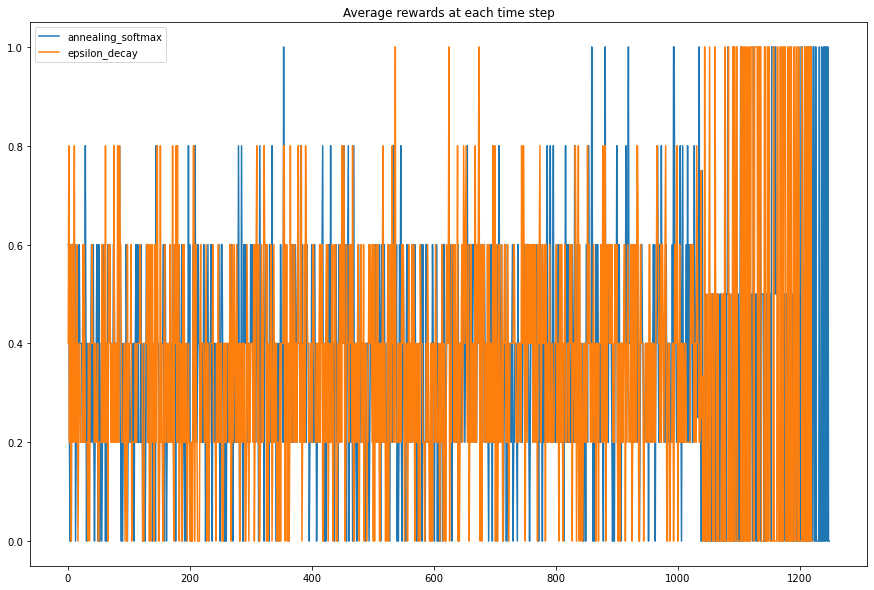

In [35]:
# Plot the rewards at each time step
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
for policy in evaluation['policy'].unique():
    results_policy = evaluation[evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

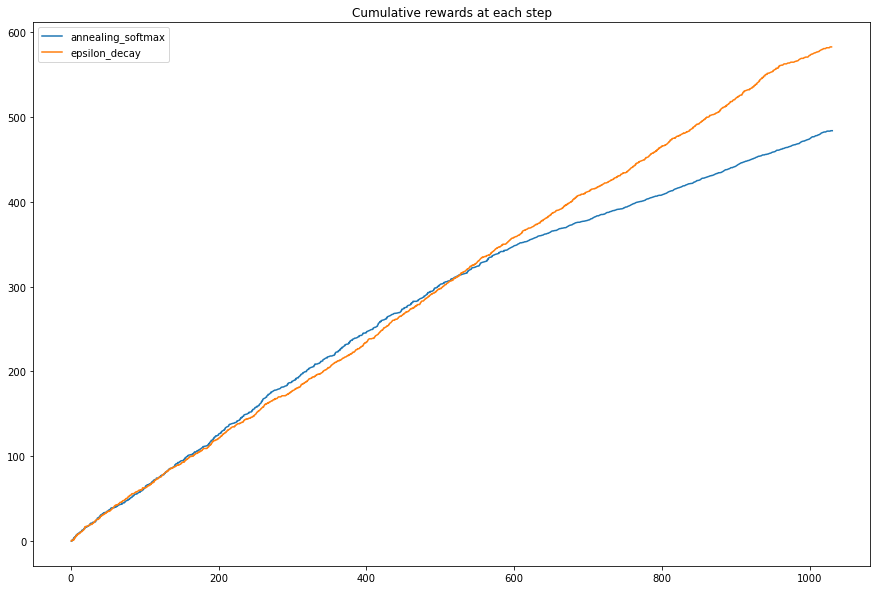

In [28]:
# Plot the cumulative rewards at each time step
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
for policy in evaluation['policy'].unique():
    results_policy = evaluation[evaluation['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
plt.legend()
plt.title("Cumulative rewards at each step")